In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import sys
import matplotlib.pyplot as plt
import random
import math
from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from sklearn.decomposition import PCA

In [ ]:
def dunn(k_list):
    """ Dunn index [CVI]
    
    Parameters
    ----------
    k_list : list of np.arrays
        A list containing a numpy array for each cluster |c| = number of clusters
        c[K] is np.array([N, p]) (N : number of samples in cluster K, p : sample dimension)
    """
    deltas = np.ones([len(k_list), len(k_list)])*10000#00
    big_deltas = np.zeros([len(k_list), 1])
    l_range = list(range(0, len(k_list)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta(k_list[k], k_list[l])
        
        big_deltas[k] = big_delta(k_list[k])

    di = np.min(deltas)/np.max(big_deltas)
    return di

def delta(ck, cl):
    values = np.ones([len(ck), len(cl)])*100#00
    
    for i in range(0, len(ck)):
        for j in range(0, len(cl)):
            values[i, j] = np.linalg.norm(ck[i]-cl[j])
            
    return np.min(values)

def big_delta(ci):
    values = np.zeros([len(ci), len(ci)])
    
    for i in range(0, len(ci)):
        for j in range(0, len(ci)):
            values[i, j] = np.linalg.norm(ci[i]-ci[j])
            
    return np.max(values)

In [ ]:
dunn_plot = np.zeros((10))

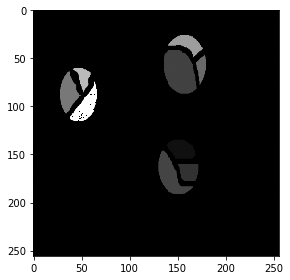

In [ ]:

mean = 0.5
var = 0.1
sigma = var ** 0.5

gaussian = np.random.normal(mean, sigma, (256, 256)) #  np.zeros((224, 224), np.float32)
gray[:, :] = gray[:, :] + gaussian

imshow(gray)

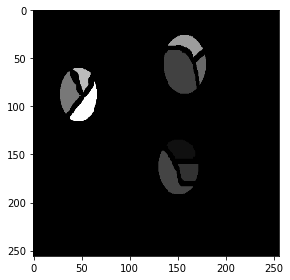

In [ ]:
  img = imread('/content/dummy2.png')
  resized_img = cv2.resize(img, (256, 256)) 
  gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
  imshow(gray)

In [ ]:
for noise in range(1):  
  img = imread('/content/dummy2.png')
  resized_img = cv2.resize(img, (256, 256)) 
  gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

  mean = noise * 0.01
  var = 0.1
  sigma = var ** 0.5

  gaussian = np.random.normal(mean, sigma, (256, 256)) #  np.zeros((224, 224), np.float32)
  #gray[:, :] = gray[:, :] + gaussian


  #thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
  output = cv2.connectedComponentsWithStats(gray, 4, cv2.CV_32S)
  (numLabels, labels, stats, centroids) = output

  #individual component mask
  componentMasks = np.zeros((numLabels +3, 256, 256))
  for cntr in range(stats.shape[0]):
      componentMasks[cntr,:,:] = (labels == cntr).astype("uint8") * 255
      
  #adding complete elements
  componentMasks[10,:,:] = (labels == 1).astype("uint8") * 255 + (labels == 2).astype("uint8") * 255 + (labels == 3).astype("uint8") * 255
  componentMasks[11,:,:] = (labels == 4).astype("uint8") * 255 + (labels == 5).astype("uint8") * 255 + (labels == 6).astype("uint8") * 255
  componentMasks[12,:,:] = (labels == 7).astype("uint8") * 255 + (labels == 8).astype("uint8") * 255 + (labels == 9).astype("uint8") * 255

  #centering individual components
  componentMasks_centered = np.zeros((numLabels+3 , 256, 256)) 
  for k in range(numLabels):
    ret,thresh = cv2.threshold(componentMasks[k],127,255,0)
    thresh = thresh.astype(np.uint8)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    for i in range(0, len(contours)):
        cnt = contours[i]
        x,y,w,h = cv2.boundingRect(cnt)
        componentMasks_centered[k,128 - h//2:128 - h//2 + h,128 - w//2:128 - w//2 + w] = componentMasks[k, y:y+h, x:x+w]

  #grouped components
  for k in range(10,13):
    ret,thresh = cv2.threshold(componentMasks[k],127,255,0)
    thresh = thresh.astype(np.uint8)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    x_min = 256
    x_max = 0
    y_min = 256
    y_max = 0
    for i in range(0, len(contours)):
          #if (i % 2 == 0):
          cnt = contours[i]
          x,y,w,h = cv2.boundingRect(cnt)
          if (x_min > x):
            x_min = x
          if (y_min > y):
            y_min = y
          if (x_max < x + w):
            x_max = x + w
          if (y_max < y + h):
            y_max = y + h
          w = x_max - x_min
          h = y_max - y_min
          #cv2.rectangle(thresh,(x,y),(x+w,y+h),(255,255,0),2)
          componentMasks_centered[k,128 - h//2:128 - h//2 + h,128 - w//2:128 - w//2 + w] = componentMasks[k, y_min:y_max, x_min:x_max]

  #Fourier mask generation
  mask= np.zeros((componentMasks_centered.shape[0], 256,256), dtype=complex)
  fourier_mag= np.zeros((componentMasks_centered.shape[0], 256,256), dtype=float)
  f_size = 15

  for ctr in range(componentMasks_centered.shape[0]):
    #for k in range(3):
    #mask[i,:,:,k] = fourier_mask(ellipse_image[:,:,k], i)
    mask[ctr,:,:] = np.fft.fftshift(np.fft.fft2((componentMasks_centered[ctr,:,:])))
    for i in range(256):
      for j in range(256):
        fourier_mag[ctr,i,j] = np.sqrt(np.square(mask[ctr,i,j].real) + np.square(mask[ctr,i,j].imag))
        '''
        if (np.isinf(fourier_mag[ctr,i,j])):
          print('hi')
          fourier_mag[ctr,i,j] = 0
        '''
  fourier_mag[np.isinf(fourier_mag)] = 0
  '''
  fig, ax = plt.subplots(1,2,figsize=(10,10))
  ax[0].imshow(np.log(abs(mask[componentMasks_centered.shape[0] -2,:,:])), cmap='gray')
  ax[0].set_title('Fourier ellipse', fontsize = f_size)

  #fourier_mag[:,:,:] = np.log(abs(fourier_mag[:,:,:]))
  ax[1].imshow(((fourier_mag[componentMasks_centered.shape[0] -1,:,:])), cmap = 'gray')
  ax[1].set_title('Greyscale Image', fontsize = f_size);
  '''


  #quantizing 16 levels
  no_of_ellipses = componentMasks_centered.shape[0]
  quant = 4
  range_gap = fourier_mag.shape[1]//quant

  a_nm = np.zeros((no_of_ellipses,quant * quant,4096))


  for k in range(no_of_ellipses):
    ctr1 = 0
    p = 0
    for i in range(quant):
      ctr2 = 0
      for j in range(quant):
        a_nm[k][p][:] = fourier_mag[k,ctr1:ctr1+range_gap,ctr2:ctr2+range_gap].flatten()
        p = p+1
        ctr2 = ctr2 + range_gap     

      ctr1 = ctr1 + range_gap

  #energy calculation
  energy_nm = np.zeros((no_of_ellipses,quant * quant))
  sum_nm = np.zeros((no_of_ellipses,quant * quant))

  for i in range(no_of_ellipses):
    for quad in range(quant * quant):
      for j in range(4096):
        sum_nm[i,quad] = sum_nm[i,quad] + a_nm[i,quad,j] ** 2
        '''
        if (math.isinf(a_nm[i,quad,j] ** 2)):
          print(a_nm[i,quad,j],i,quad,j)
        '''
      energy_nm[i,quad] = np.sqrt(sum_nm[i,quad])
      
  print(noise)
  dunn_plot[noise] = dunn(sum_nm)

0


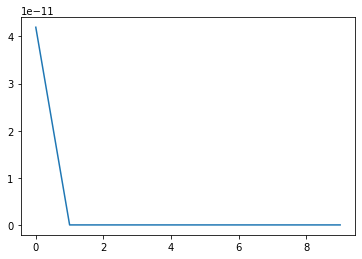

In [ ]:
plt.plot(dunn_plot)  # A higher Dunn index indicates better clustering

In [ ]:
dunn_plot[0] = dunn(sum_nm)

4.194432321338404e-11

In [ ]:
dunn_plot[0] = 4.194432321338404e-11
dunn_plot[1] = 3.494e-11
dunn_plot[2] = 3.17e-11
dunn_plot[3] = 3.00e-11
dunn_plot[4] = 2.76e-11
dunn_plot[5] = 2.1e-11
dunn_plot[6] = 1.6e-11
dunn_plot[7] = 1.2e-11
dunn_plot[8] = 0

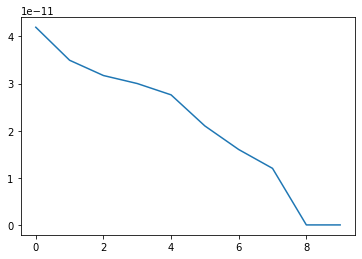

In [ ]:
plt.plot(dunn_plot)  #shape distortion (increasing differences in major and minor axis of ellipses)

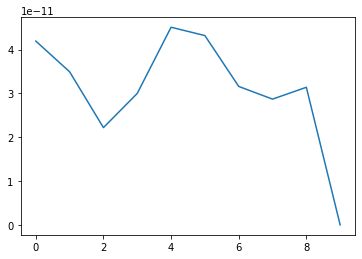

In [ ]:
dunn_plot[1] = 3.494e-11
dunn_plot[2] = 2.22e-11
dunn_plot[3] = 3.00e-11
dunn_plot[4] = 4.51e-11
dunn_plot[5] = 4.32e-11
dunn_plot[6] = 3.16e-11
dunn_plot[7] = 2.87e-11
dunn_plot[8] = 3.14e-11

plt.plot(dunn_plot)  #location shift ()